# Convolutional Neural Network in Keras

Bulding a Convolutional Neural Network to classify Fashion-MNIST.

#### Set seed for reproducibility

In [1]:
import numpy as np
np.random.seed(42)

#### Load dependencies

In [17]:
import os

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Activation, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

from keras_contrib.layers.advanced_activations.sinerelu import SineReLU

from matplotlib import pyplot as plt

%matplotlib inline

#### Load data

In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

#### Preprocess data
Flatten and normalise input data.

In [4]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

In [5]:
# One-hot encoded categories
n_classes = 10
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

#### Design Neural Network architecture

In [6]:
model = Sequential()

model.add(Conv2D(32, 7, padding = 'same', input_shape = (28, 28, 1)))
# model.add(LeakyReLU(alpha=0.01))
model.add(Activation('relu'))

model.add(Conv2D(32, 7, padding = 'same'))
# model.add(LeakyReLU(alpha=0.01))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, 3, padding = 'same'))
# model.add(LeakyReLU(alpha=0.01))
model.add(Activation('relu'))

model.add(Conv2D(64, 3, padding = 'same'))
# model.add(LeakyReLU(alpha=0.01))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.30))

model.add(Conv2D(128, 2, padding = 'same'))
# model.add(LeakyReLU(alpha=0.01))
model.add(Activation('relu'))

model.add(Conv2D(128, 2, padding = 'same'))
# model.add(LeakyReLU(alpha=0.01))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(512))
# model.add(LeakyReLU(alpha=0.01))
model.add(Activation('relu'))
model.add(Dropout(0.50))

model.add(Dense(10, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        1600      
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        50208     
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1

#### Callbacks

In [7]:
modelCheckpoint = ModelCheckpoint(monitor='val_accuracy', filepath='model_output/weights-cnn-fashion-mnist.hdf5',
                                               save_best_only=True, mode='max')
earlyStopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)


if not os.path.exists('model_output'):
    os.makedirs('model_output')

tensorboard = TensorBoard("logs/convnet-fashion-mnist")

#### Configure model

In [8]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

#### Train!

In [9]:
history = model.fit(X_train, y_train, batch_size = 128, epochs = 20, verbose = 1,
          validation_split = 0.1, callbacks=[modelCheckpoint, earlyStopping, tensorboard])

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 109s 2ms/sample - loss: 0.6916 - accuracy: 0.7466 - val_loss: 0.3887 - val_accuracy: 0.8520
Epoch 2/20
54000/54000 [==============================] - 117s 2ms/sample - loss: 0.3989 - accuracy: 0.8529 - val_loss: 0.3361 - val_accuracy: 0.8700
Epoch 3/20
54000/54000 [==============================] - 121s 2ms/sample - loss: 0.3469 - accuracy: 0.8699 - val_loss: 0.3039 - val_accuracy: 0.8810
Epoch 4/20
54000/54000 [==============================] - 123s 2ms/sample - loss: 0.3211 - accuracy: 0.8813 - val_loss: 0.2813 - val_accuracy: 0.8910
Epoch 5/20
54000/54000 [==============================] - 124s 2ms/sample - loss: 0.2967 - accuracy: 0.8898 - val_loss: 0.2733 - val_accuracy: 0.8988
Epoch 6/20
54000/54000 [==============================] - 127s 2ms/sample - loss: 0.2849 - accuracy: 0.8936 - val_loss: 0.2595 - val_accuracy: 0.8993
Epoch 7/20
54000/54000 [===========================

#### Test Predictions

In [11]:
saved_model = load_model('model_output/weights-cnn-fashion-mnist.hdf5')
predictions = saved_model.predict_classes(X_test, verbose = 2)
print(predictions)
# np.std(history.history['loss'])

10000/1 - 9s
[9 2 1 ... 8 1 5]


#### Test Final Accuracy

In [12]:
final_loss, final_acc = saved_model.evaluate(X_test, y_test, verbose = 2)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

10000/1 - 8s - loss: 0.2481 - accuracy: 0.9221
Final loss: 0.2229, final accuracy: 0.9221


In [13]:
image = X_test[0].reshape(1, 28, 28, 1)

In [14]:
predictions = model.predict_classes(image, verbose = 2)
print(predictions)

1/1 - 0s
[9]


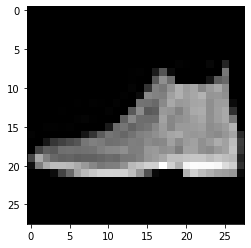

In [18]:
plt.imshow(X_test[0].reshape((28, 28)), cmap='gray')

In [ ]:
# 0 T-shirt/top
# 1 Trouser
# 2 Pullover
# 3 Dress
# 4 Coat
# 5 Sandal
# 6 Shirt
# 7 Sneaker
# 8 Bag
# 9 Ankle boot